# PHYS142 Final Project: 2D Ising Model with MCMC Group B
Group members: Matthew Yao, Ashlean Chen, Sophie Carlson

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import tqdm
import numba as nb
%matplotlib widget

In [137]:
# numba implementation of Metropolis-Hastings algorithm
# 300x faster than reference implementation
@nb.njit
def ising_mcmc_numba(lattice_spins, STEPS, rand, rand_pos, T, B):
    # INPUTS: 
    #   lattice_spins: 2d np array of initial spins
    #   STEPS: number of steps
    #   rand: list of random numbers [0, 1] of length STEPS 
    #   rand_pos: list of random positions (i, j) of length STEPS
    #   T: temperature
    #   B: external magnetic field

    # Outputs: 
    # Tuple (num_accept, m_values)
    #     num_accept: number of spin flips
    #     m_values: np array of m values 

    m_values = np.zeros(STEPS)
    sum_spins = np.sum(lattice_spins)
    num_accept = 0
    for t in range(STEPS):
        i, j = rand_pos[t]
        delta_energy = -2 * B * lattice_spins[i, j]
            
        i_neigh = i + -1 if i + -1 < N else 0
        j_neigh = j + 0 if j + 0 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 1 if i + 1 < N else 0
        j_neigh = j + 0 if j + 0 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 0 if i + 0 < N else 0
        j_neigh = j + 1 if j + 1 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 0 if i + 0 < N else 0
        j_neigh = j + -1 if j + -1 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
            
        if delta_energy <= 0:
            lattice_spins[i, j] *= -1
            sum_spins += 2*lattice_spins[i, j]
            num_accept += 1
        elif delta_energy > 0:
            prob = np.exp(-delta_energy / (KB * T))
            if rand[t] < prob:
                lattice_spins[i, j] *= -1
                sum_spins += 2*lattice_spins[i, j]
                num_accept += 1
        m_values[t] = sum_spins / N**2
    return (num_accept, m_values)

# Wrapper for above which generates random data
def ising_mcmc(lattice_spins, STEPS, T, B):
    # INPUTS: 
    #   lattice_spins: 2d np array of initial spins
    #   STEPS: number of steps
    #   T: temperature
    #   B: external magnetic field
    # Outputs: 
    # Tuple (num_accept, m_values)
    #     num_accept: number of spin flips
    #     m_values: np array of m values 
    rand = np.random.rand(STEPS)
    rand_pos = np.random.randint(0, N, size=(STEPS, 2))
    return ising_mcmc_numba(lattice_spins, STEPS, rand, rand_pos, T, B)

In [143]:
STEPS = 1_000_000
N = 100
J = 1
KB = 1
T = 5
B = 1

lattice_spins = np.ones((N, N))
m_values = np.zeros(STEPS)
num_accept, m_values = ising_mcmc(lattice_spins, STEPS, T, B)

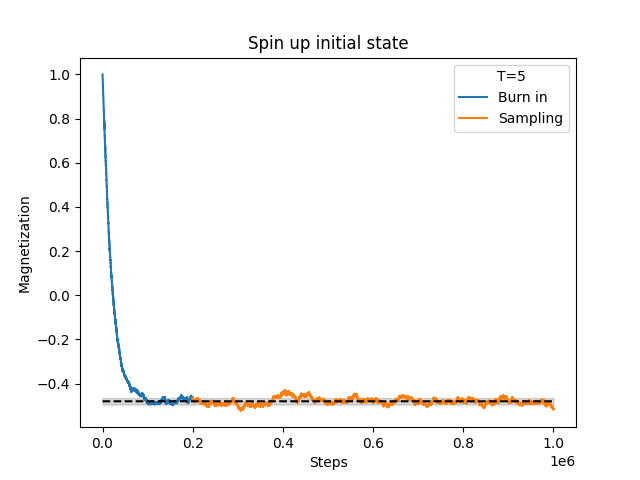

magnetization mean = -0.48010599324999986
magnetization std = 0.01475297155765423


In [140]:
BURNIN = 200_000

m_mean = np.mean(m_values[BURNIN:])
m_std = np.std(m_values[BURNIN:])

plt.figure()
plt.plot(range(STEPS)[:BURNIN], m_values[:BURNIN], label="Burn in")
plt.plot(range(STEPS)[BURNIN:], m_values[BURNIN:], label="Sampling")
# show mean as dashed line
plt.plot(range(STEPS), m_mean * np.ones((STEPS)), "--", color="black")
# show variance as filled box
plt.fill_between(range(STEPS), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Magnetization")
plt.title("Spin up initial state")
plt.legend(title=f"T={T}")
#plt.savefig('figures/spinup.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

print(f"magnetization mean = {m_mean}")
print(f"magnetization std = {m_std}")

In [144]:
temps = np.arange(.5, 20.0, .1)
m_values_list = []
m_mean_list = []
m_std_list = []
for T in tqdm.tqdm(temps):
    BURNIN = 200_000
    STEPS = 1_000_000

    lattice_spins = np.ones((N, N))

    rand = np.random.rand(STEPS)
    rand_pos = np.random.randint(0, N, size=(STEPS, 2))
    lattice_spins = np.ones((N, N))
    m_values = np.zeros(STEPS)

    num_accept, m_values = mcmc(lattice_spins, STEPS, rand, rand_pos, m_values, T, 1)
    m_mean = np.mean(m_values[BURNIN:])
    m_std = np.std(m_values[BURNIN:])
    m_values_list.append(m_values)
    m_mean_list.append(m_mean)
    m_std_list.append(m_std)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:08<00:00, 22.18it/s]


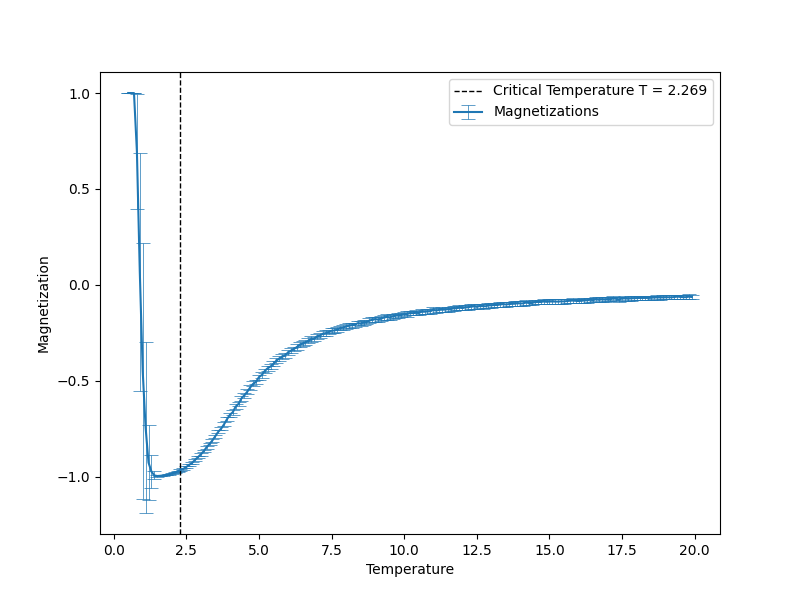

In [145]:
fig = plt.figure(figsize = (8,6))
plt.errorbar(temps, m_mean_list, yerr=m_std_list, capsize=5, capthick=.5, elinewidth=.5, label="Magnetizations")
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.axvline(x=2.269, color='black', linestyle='--', linewidth = 1, label="Critical Temperature T = 2.269")
plt.legend()
#plt.savefig('figures/crit.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()